In [1]:
!pip install cython pyyaml
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-kefljhug
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-kefljhug
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=109312 sha256=d05a32256a1ef022bc791a542905e4135463f9013e046958239c3f8b247ad8f2
  Stored in directory: /tmp/pip-ephem-wheel-cache-jjtpg4qr/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
2.1.2 True
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
torch.__version__

'2.1.2'

In [3]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ey8_m2kp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ey8_m2kp
  Resolved https://github.com/facebookresearch/detectron2.git to commit cc9266c2396d5545315e3601027ba4bc28e8c95b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 823.1 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 8.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
torch:  2.1 ; cuda:  2.1.2
detectron2: 0.6


In [5]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [6]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train_dataset", {}, "/kaggle/input/detectron2/train/_annotations.coco.json", "/kaggle/input/detectron2/train")
register_coco_instances("val_dataset", {}, "/kaggle/input/detectron2/valid/_annotations.coco.json", "/kaggle/input/detectron2/valid")
register_coco_instances("test_dataset", {}, "/kaggle/input/detectron2/test/_annotations.coco.json", "/kaggle/input/detectron2/test")

WARNING [03/15 11:17:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/15 11:17:49 d2.data.datasets.coco]: Loaded 36 images in COCO format from /kaggle/input/detectron2/train/_annotations.coco.json


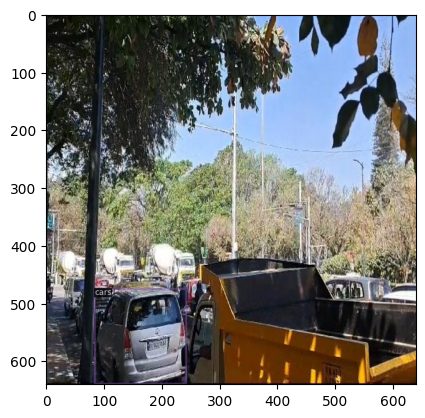

In [7]:
#visualize training data
train_metadata = MetadataCatalog.get("train_dataset")
dataset_dicts = DatasetCatalog.get("train_dataset")

import random
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_dataset",)
cfg.DATASETS.TEST = ("test_dataset",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = (1000, 1500)       # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [9]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [24]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[03/15 11:39:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


WARNING [03/15 11:40:08 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/15 11:40:08 d2.data.datasets.coco]: Loaded 2 images in COCO format from /kaggle/input/detectron2/test/_annotations.coco.json
Instances(num_instances=4, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[368.4556, 437.8377, 640.0000, 640.0000],
        [278.4556, 392.1374, 373.0821, 499.6962],
        [360.2935, 418.5469, 498.9481, 523.4731],
        [474.3534, 408.1609, 599.9306, 462.7677]], device='cuda:0')), scores: tensor([0.9899, 0.9859, 0.9856, 0.9393], device='cuda:0'), pred_classes: tensor([1, 1, 1, 1], device='cuda:0')])
Instances(num_instances=4, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([[143.4142, 425.7600, 279.8457, 560.9191],
        [265.1521, 430.2439, 502.1161, 640.0000],
        [435.4424, 462.8434, 640.0000, 640.0000],
        [535.5868, 410.7052, 640.0000, 482.6830]], device='cuda:0'

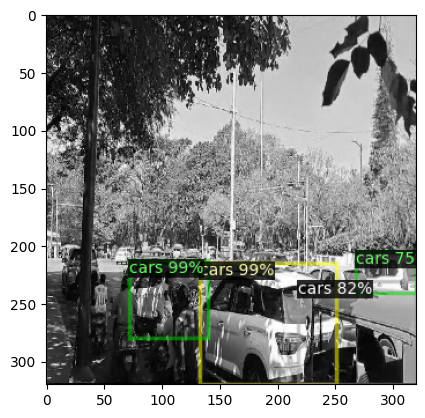

In [25]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("test_dataset")
test_metadata = MetadataCatalog.get("test_dataset")
for d in random.sample(dataset_dicts, 2):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    print(outputs["instances"])
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])

In [ ]:
import pathlib
from yolov5.utils.general import (
    check_img_size, non_max_suppression, scale_boxes, xyxy2xywh)
from yolov5.utils.torch_utils import select_device, time_sync
from yolov5.utils.datasets import letterbox

from utils_ds.parser import get_config
from utils_ds.draw import draw_boxes
from deep_sort import build_tracker

import argparse
import os
import time
import numpy as np
import warnings
import cv2
import torch
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import sys

currentUrl = os.path.dirname(__file__)
sys.path.append(os.path.abspath(os.path.join(currentUrl, 'yolov5')))


cudnn.benchmark = True

temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath


class VideoTracker(object):
    def __init__(self):
        print('Initialize DeepSORT & YOLO-V5')
        # ***************** Initialize ******************************************************
        self.args = args

        # image size in detector, default is 640
        self.img_size = 640
        self.frame_interval = 2       # frequency

        self.device = 'cuda'
        self.half = self.device.type != 'cpu'  # half precision only supported on CUDA


        self.vdo = cv2.VideoCapture()

        # ***************************** initialize DeepSORT **********************************
        cfg = get_config()
        cfg.merge_from_file(args.config_deepsort)

        use_cuda = self.device.type != 'cpu' and torch.cuda.is_available()
        self.deepsort = build_tracker(cfg, use_cuda=use_cuda)

        # ***************************** initialize YOLO-V5 **********************************
        self.detector = predictor
        # get number of input features for the classifier
#         in_features = self.detector.roi_heads.box_predictor.cls_score.in_features
        # replace the pre-trained head with a new one
#         self.detector.roi_heads.box_predictor = FastRCNNPredictor(
#             in_features, 2)
#         self.detector.load_state_dict(torch.load(
#             'model'))
#         self.detector.to(self.device).eval()
        if self.half:
            self.detector.half()  # to FP16

        # self.names = self.detector.module.names if hasattr(
        #     self.detector, 'module') else self.detector.names

        print('Done..')
        if self.device == 'cpu':
            warnings.warn(
                "Running in cpu mode which maybe very slow!", UserWarning)

    def __enter__(self):
        # ************************* Load video from camera *************************

        
        assert os.path.isfile(self.args.input_path), "Path error"
        self.vdo.open(self.args.input_path)
        self.im_width = int(self.vdo.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.im_height = int(self.vdo.get(cv2.CAP_PROP_FRAME_HEIGHT))
        assert self.vdo.isOpened()
        print('Done. Load video file ', self.args.input_path)

        # ************************* create output *************************
        if self.args.save_path:
            os.makedirs(self.args.save_path, exist_ok=True)
            # path of saved video and results
            self.save_video_path = os.path.join(
                self.args.save_path, "results.mp4")

            # create video writer
            fourcc = cv2.VideoWriter_fourcc(*self.args.fourcc)
            self.writer = cv2.VideoWriter(self.save_video_path, fourcc,
                                          self.vdo.get(cv2.CAP_PROP_FPS), (self.im_width, self.im_height))
            print('Done. Create output file ', self.save_video_path)

        if self.args.save_txt:
            os.makedirs(self.args.save_txt, exist_ok=True)

        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.vdo.release()
        self.writer.release()
        if exc_type:
            print(exc_type, exc_value, exc_traceback)

    def run(self):
        yolo_time, sort_time, avg_fps = [], [], []
        t_start = time.time()

        idx_frame = 0
        last_out = None
        cars = set()
        while self.vdo.grab():
            # Inference *********************************************************************
            t0 = time.time()
            _, img0 = self.vdo.retrieve()

            if idx_frame % self.args.frame_interval == 0:
                outputs, yt, st = self.image_track(
                    img0)        # (#ID, 5) x1,y1,x2,y2,id
                last_out = outputs
                yolo_time.append(yt)
                sort_time.append(st)
                print('Frame %d Done. YOLO-time:(%.3fs) SORT-time:(%.3fs)' %
                      (idx_frame, yt, st))
            else:
                outputs = last_out  # directly use prediction in last frames
            t1 = time.time()
            avg_fps.append(t1 - t0)

            # post-processing ***************************************************************
            # visualize bbox  ********************************
            count = 0
            if len(outputs) > 0:
                bbox_xyxy = outputs[:, :4]
                identities = outputs[:, -1]
                img0 = draw_boxes(img0, bbox_xyxy, identities)  # BGR
                cars.update(identities)
                # add FPS information on output video
                text_scale = max(1, img0.shape[1] // 1600)
                cv2.putText(img0, 'frame: %d fps: %.2f car count : %d' % (idx_frame, len(avg_fps) / sum(avg_fps), len(cars)),
                            (20, 20 + text_scale), cv2.FONT_HERSHEY_PLAIN, text_scale, (0, 0, 255), thickness=2)

            # display on window ******************************
            if self.args.display:
                cv2.imshow("test", img0)
                if cv2.waitKey(1) == ord('q'):  # q to quit
                    cv2.destroyAllWindows()
                    break

            # save to video file *****************************
            if self.args.save_path:
                self.writer.write(img0)

            if self.args.save_txt:
                with open(self.args.save_txt + str(idx_frame).zfill(4) + '.txt', 'a') as f:
                    for i in range(len(outputs)):
                        x1, y1, x2, y2, idx = outputs[i]
                        f.write('{}\t{}\t{}\t{}\t{}\n'.format(
                            x1, y1, x2, y2, idx))

            idx_frame += 1

        print('Avg YOLO time (%.3fs), Sort time (%.3fs) per frame' % (sum(yolo_time) / len(yolo_time),
                                                                      sum(sort_time)/len(sort_time)))
        t_end = time.time()
        print('Total time (%.3fs), Total Frame: %d' %
              (t_end - t_start, idx_frame))

    def apply_nms(self, orig_prediction, iou_thresh=0.2):

        # torchvision returns the indices of the bboxes to keep
        keep = torchvision.ops.nms(
            orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

        final_prediction = orig_prediction
        final_prediction['boxes'] = final_prediction['boxes'][keep]
        final_prediction['scores'] = final_prediction['scores'][keep]
        final_prediction['labels'] = final_prediction['labels'][keep]

        return final_prediction

    def image_track(self, im0):
        """
        :param im0: original image, BGR format
        :return:
        """
        # preprocess ************************************************************
        # Padded resize
        img = letterbox(im0, new_shape=self.img_size)[0]
        # Convert
        img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
        img = np.ascontiguousarray(img)

        # numpy to tensor
        img = torch.from_numpy(img).to(self.device)
        img = img.half() if self.half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)
        s = '%gx%g ' % img.shape[2:]    # print string

        # Detection time *********************************************************
        # Inference
        t1 = time_sync()
        with torch.no_grad():
            pred = self.detector(img)[
                0]  # list: bz * [ (#obj, 6)]
        # print(pred)
        # Apply NMS and filter object other than person (cls:0)
        pred = self.apply_nms(pred)
        t2 = time_sync()

        nms_boxes = pred['boxes']
        nms_labels = pred['labels']
        nms_scores = pred['scores']

        bbox_xywh = xyxy2xywh(nms_boxes)

        outputs = self.deepsort.update(bbox_xywh, nms_scores, im0)
        t3 = time_sync()
        return outputs, t2-t1, t3-t2




    with VideoTracker() as vdo_trk:
        vdo_trk.run()
